### Imports

In [24]:
%load_ext autoreload
%autoreload 2

from util.data import load_data, replace_categorical, split_data, train_val_test_split, summarize_columns, normalize, mess_up_selected
from util.visualizations import plot_frequencies
from util.model import BaselineModel
from util.feature_importance import explain_model_with_shap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from util.visualizations import plot_all_features
from util.data import impute_data
from sklearn.metrics import mean_absolute_error
from util.cost_model import calculate_metrics
from util.model import L1Model
from util.model import XGBoostModel
from util.model import NeuroProbabilisticModel
from util.cost_model import CustomNeuroLoss
from util.visualizations import plot_learning_curves_neuro, plot_learning_curves_xgboost

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project in AI in Industry: Predicting Road Accident Risk

**About the dataset**:

The dataset we are going to be using is a synthetically generated dataset taken from one of Kaggles playground-series competitions (season 5, episode 10 to be exact).

The link to the competition (and dataset), can be found [by clicking here.](https://www.kaggle.com/competitions/playground-series-s5e10/overview)

To make the dataset relevant for this subject; "AI in Industry", we have made our own industry-like interpretation of the task. We also corrupted the dataset a bit by introdusing missing values to further emulate the "industry" and "real world" aspect of the task.

Since the Kaggle competition has closed, and to avoid having to deal with their API, we have taken some of the training data and used it as test data.


**Our industry-interpretation**: 

A company has curated a dataset with road information, like e.g. curvature, and had experts analyse each road to figure out an accident risk. 

The problem is that these experts arent always available, and the company therefore wants an algorithm to estimate risks for new roads. 

An additional difficulty, is that the company would prefer that we dont underrestimate these risks, as underrestimated risks will cost the company alot in the future. 

As a final note, the company knows their database is lacking alot of values for many of their rows, so they are also interrested in finding out what features are the best predictors, so that they can focus on gathering the missing data for those features.

### Important constants

In [25]:
TRAIN_DATA = "data/train.csv"
TEST_DATA  = "data/test.csv"
TARGET_COL = "accident_risk"

PENALTY_UNDERESTIMATE = 5

## Preprocess data

### Checking out data

In [26]:
# Fetch data
data = load_data(TRAIN_DATA)

summarize_columns(data)

id: Range: 0 to 517753
road_type: Categories: ['urban', 'rural', 'highway']
num_lanes: Range: 1 to 4
curvature: Range: 0.0 to 1.0
speed_limit: Range: 25 to 70
lighting: Categories: ['daylight', 'dim', 'night']
weather: Categories: ['rainy', 'clear', 'foggy']
road_signs_present: Range: False to True
public_road: Range: False to True
time_of_day: Categories: ['afternoon', 'evening', 'morning']
holiday: Range: False to True
school_season: Range: False to True
num_reported_accidents: Range: 0 to 7
accident_risk: Range: 0.0 to 1.0


In [27]:
# Replace categories with one-hot encodings and booleans with 0/1s
data_cleaned = replace_categorical(data)

# Introduce NaNs to simulate industrial setting
data_messy = mess_up_selected(data_cleaned, [TARGET_COL])

summarize_columns(data_cleaned)

num_lanes: Range: 1.0 to 4.0
curvature: Range: 0.0 to 1.0
speed_limit: Range: 25.0 to 70.0
road_signs_present: Range: 0.0 to 1.0
public_road: Range: 0.0 to 1.0
holiday: Range: 0.0 to 1.0
school_season: Range: 0.0 to 1.0
num_reported_accidents: Range: 0.0 to 7.0
accident_risk: Range: 0.0 to 1.0
road_type_rural: Range: 0.0 to 1.0
road_type_urban: Range: 0.0 to 1.0
lighting_dim: Range: 0.0 to 1.0
lighting_night: Range: 0.0 to 1.0
weather_foggy: Range: 0.0 to 1.0
weather_rainy: Range: 0.0 to 1.0
time_of_day_evening: Range: 0.0 to 1.0
time_of_day_morning: Range: 0.0 to 1.0


In [28]:
data_messy.head(5)

,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,time_of_day_evening,time_of_day_morning
0,2.0,0.06,35.0,0.0,1.0,0.0,1.0,1.0,0.13,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4.0,0.99,35.0,1.0,0.0,1.0,1.0,0.0,0.35,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.0,0.63,70.0,NaN,1.0,1.0,0.0,2.0,0.30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4.0,0.07,35.0,1.0,1.0,NaN,0.0,1.0,0.21,0.0,NaN,1.0,NaN,0.0,1.0,0.0,1.0
4,1.0,0.58,60.0,0.0,0.0,1.0,0.0,1.0,0.56,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [29]:
X, Y = split_data(data_cleaned, TARGET_COL)

print(f'''
Missing values in target: {Y.isna().sum()}
Missing values in features: 
{X.isna().sum()}
''')


Missing values in target: 0
Missing values in features: 
num_lanes                 25764
curvature                 25817
speed_limit               25872
road_signs_present        25380
public_road               25910
holiday                   25984
school_season             25469
num_reported_accidents    26272
road_type_rural           25797
road_type_urban           25808
lighting_dim              26089
lighting_night            25735
weather_foggy             25945
weather_rainy             26165
time_of_day_evening       25751
time_of_day_morning       26046
dtype: int64



In [30]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = train_val_test_split(X, Y)

print(f'''
Sanity checks:

Data: Rows: {len(data)}, Columns: {len(data.columns)},
Sum train, val, test: {len(X_train)+len(X_val)+len(X_test)}

X train length: {len(X_train)}, Columns: {len(X_train.columns)}
X test length: {len(X_test)}, Columns: {len(X_test.columns)}

X val length: {len(X_val)}, Columns: {len(X_val.columns)}
X test length: {len(X_test)}, Columns: {len(X_test.columns)}
''')


Sanity checks:

Data: Rows: 517754, Columns: 14,
Sum train, val, test: 517754

X train length: 414202, Columns: 16
X test length: 51776, Columns: 16

X val length: 51776, Columns: 16
X test length: 51776, Columns: 16



In [31]:
X_train.head(5)

,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,time_of_day_evening,time_of_day_morning
393568,2.0,0.86,35.0,1.0,0.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,NaN,0.0,1.0
259815,NaN,0.08,70.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0
72423,4.0,0.33,35.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
342049,3.0,0.10,45.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
47829,3.0,0.66,45.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,NaN,0.0,0.0,0.0


In [32]:
Y_train.head(5)

393568    0.29
259815    0.37
72423     0.24
342049    0.38
47829     0.49
Name: accident_risk, dtype: float64

Plot distributions (minus NaNs)

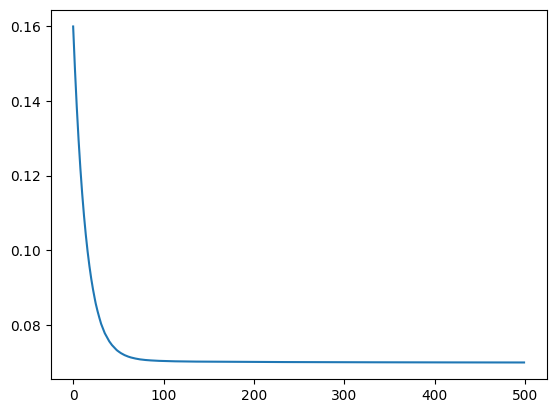

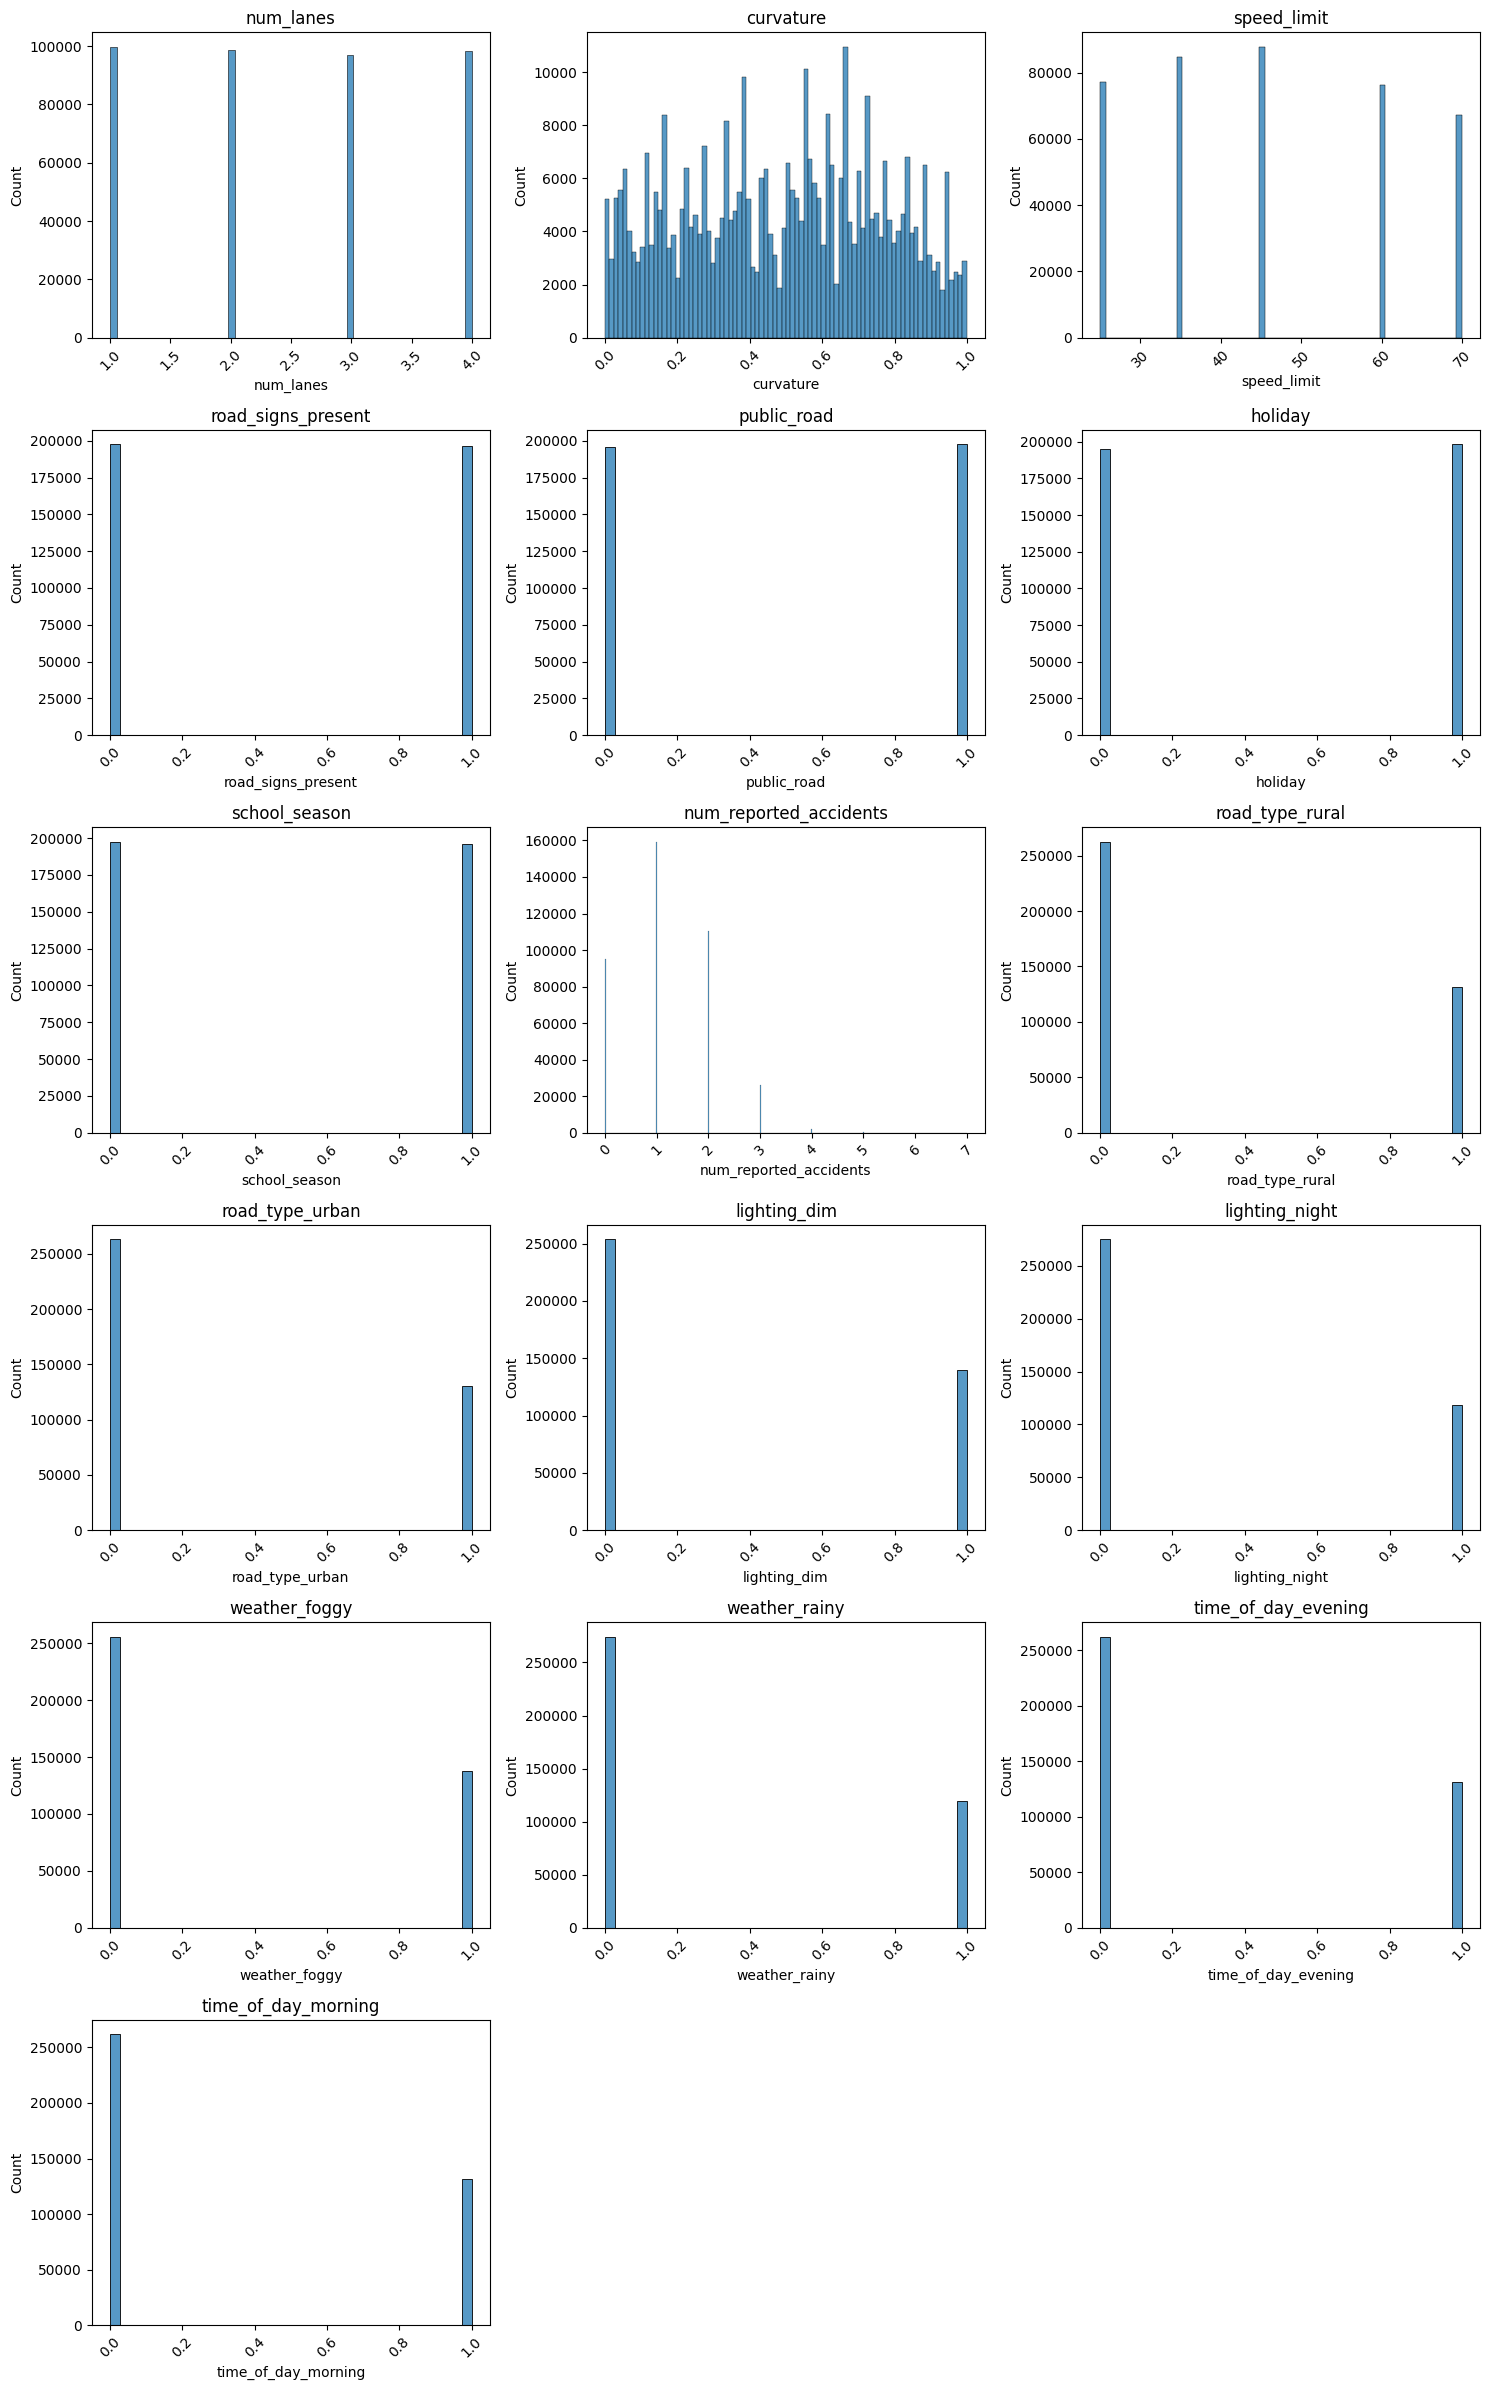

In [33]:
plot_frequencies(X_train)

We see that some features have larger scales, so we normalize them to prevent them from dominating the model.

We just use a Min Max scaler for ``speed_limit`` and ``num_lanes`` as there are no outliers that would shrink the values of the "standard" data.

We use Standard-Scaler for ``num_reported_accidents`` since the outliers would shrink the "standard" data.

In [34]:
features_to_normalize = ["speed_limit", "num_lanes"]
features_to_standardize = ["num_reported_accidents"]

X_train, X_val, X_test = normalize(X_train, X_val, X_test, features_to_normalize, MinMaxScaler())
X_train, X_val, X_test = normalize(X_train, X_val, X_test, features_to_standardize, StandardScaler())

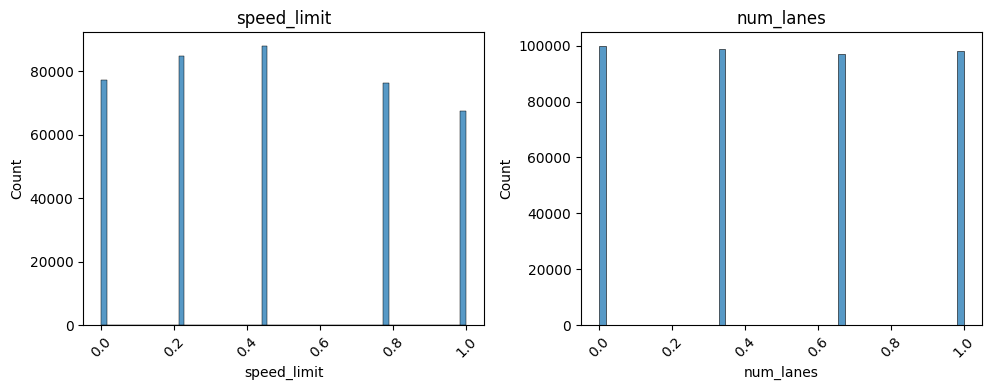

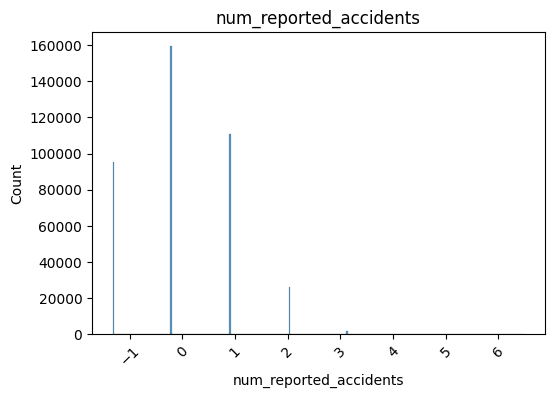

In [35]:
plot_frequencies(X_train[features_to_normalize])
plot_frequencies(X_train[features_to_standardize])

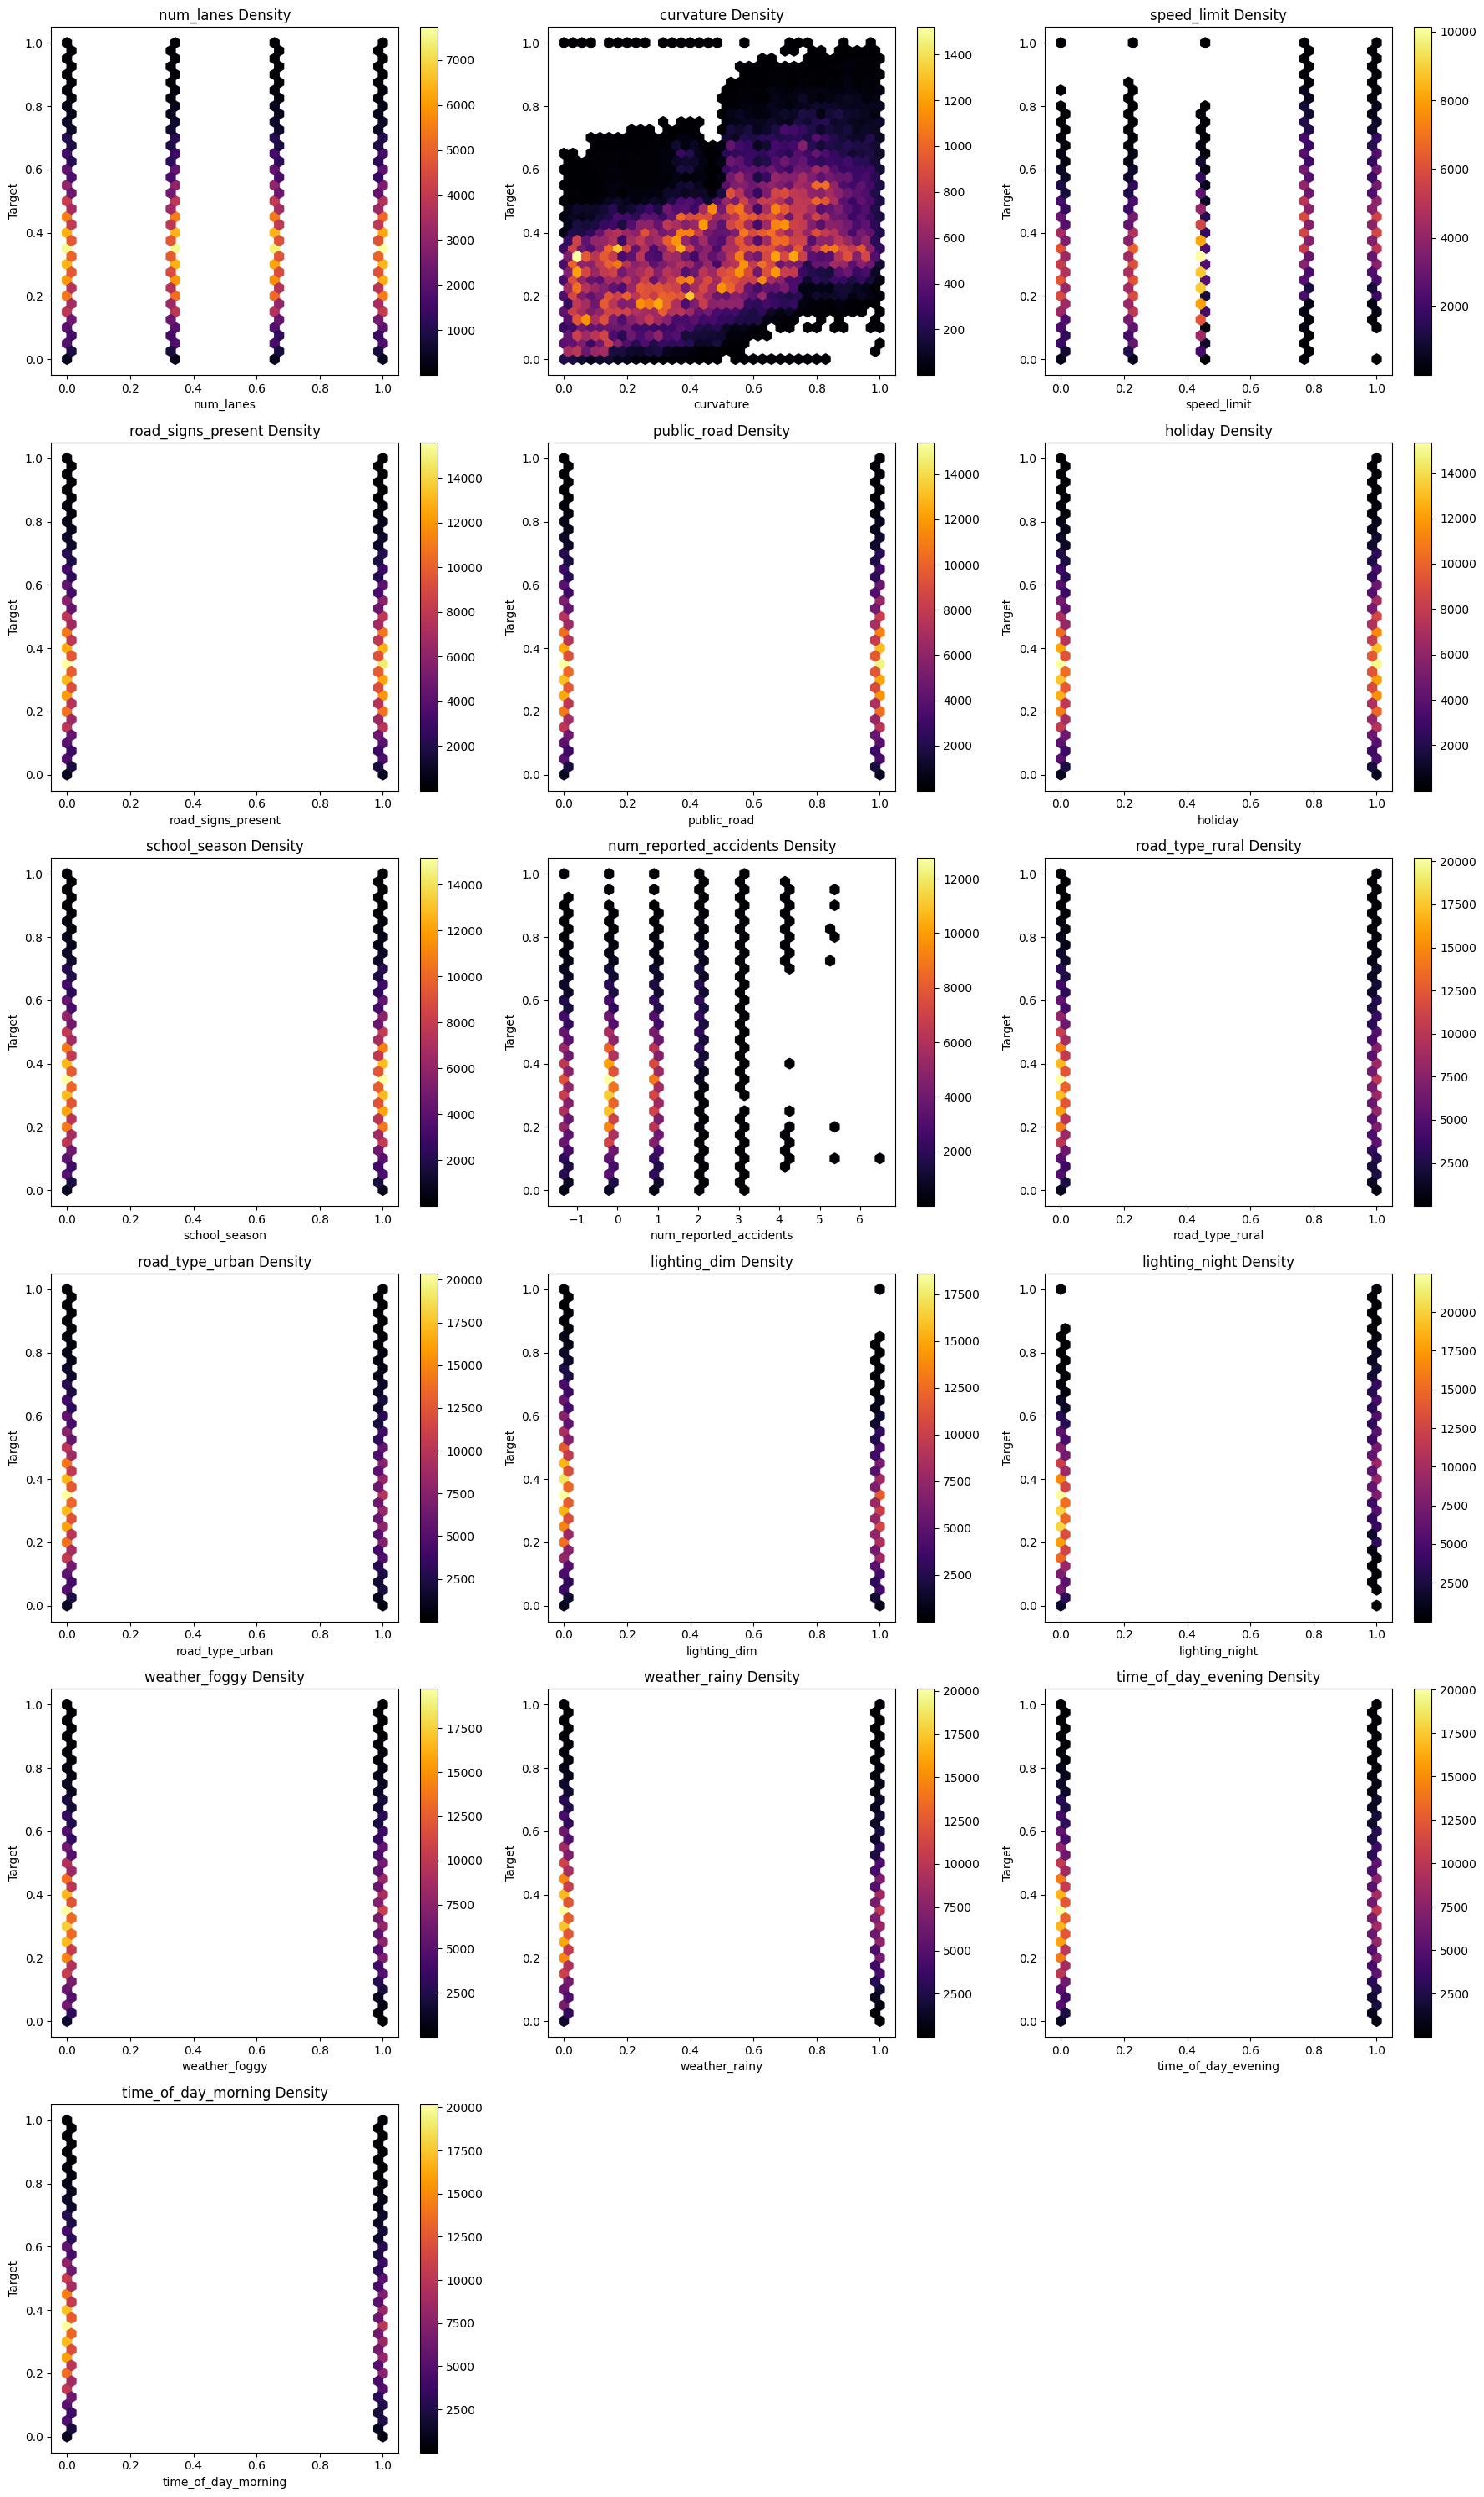

In [36]:
plot_all_features(X_train, Y_train)

By looking at the correlations we can start to get ideas about what features might be important.

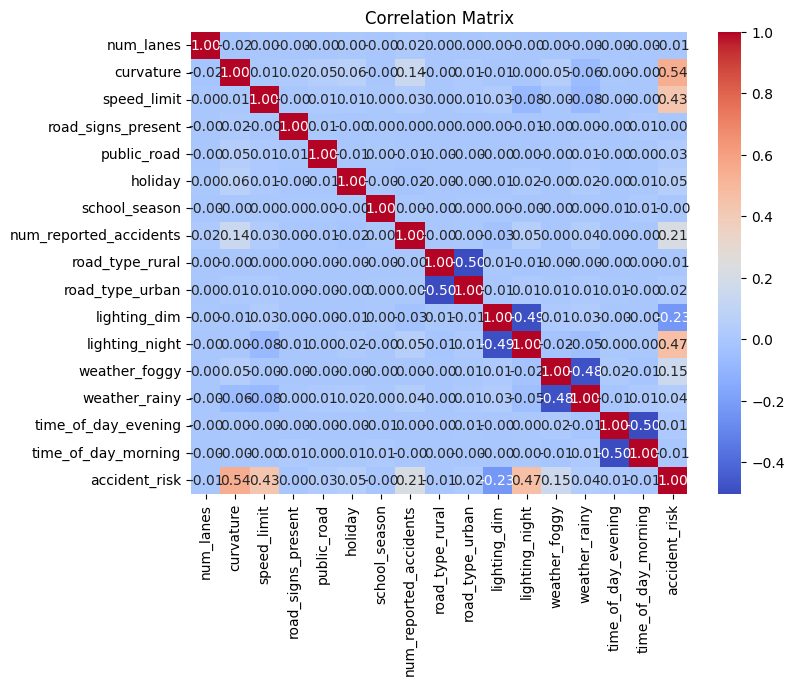

In [37]:
combined = pd.concat([X_train, Y_train], axis=1)
corrs = combined.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corrs, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We can see that ``lighting_night``, ``weather_foggy``, ``num_reported_accidents``, ``speed_limit``, and ``curvature`` all might be useful features to predict ``accident_risk``. However this does not rule out that other features might be important as well, just that those features does not have a linear correlation with the number of accidents.

## Testing different models and imputation methods

First we try to impute using mean for curvature (as its the least categorical), and median for the rest

We dont need to impute accident risk as the target isnt missing any values

In [38]:
X_train_imp, X_val_imp, X_test_imp = impute_data(X_train, X_val, X_test, ["curvature"], "mean", "median")

### Model 1 - Linear regression

We start with linear regression to get a baseline

In [39]:

BaseModel = BaselineModel()
BaseModel.fit(X_train_imp, Y_train)

Y_predictions_basemodel = BaseModel.predict(X_test_imp)

metrics_df = calculate_metrics(Y_test, Y_predictions_basemodel, PENALTY_UNDERESTIMATE, "Linear")

metrics_df

,Model,Cost,Standard MAE,RMSE,R2 Score,Underestimated portion,Overestimated portion
0,Linear,0.19278,0.064792,0.083001,0.750327,0.484317,0.515683


The standard linear regressor does quite well, reaching a low Mean Absolute Error. 

The cost (custom weighted MAE) however, is relatively high, as it underestimates about as much as it overestimates, leading to high punishments

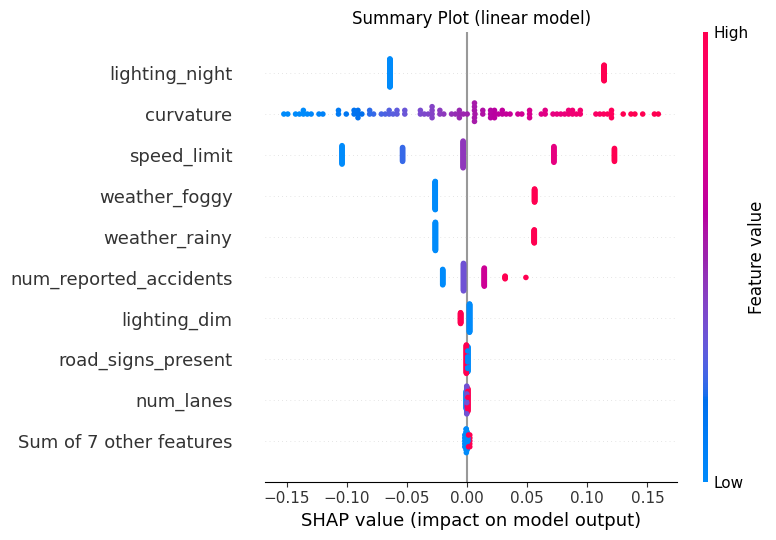

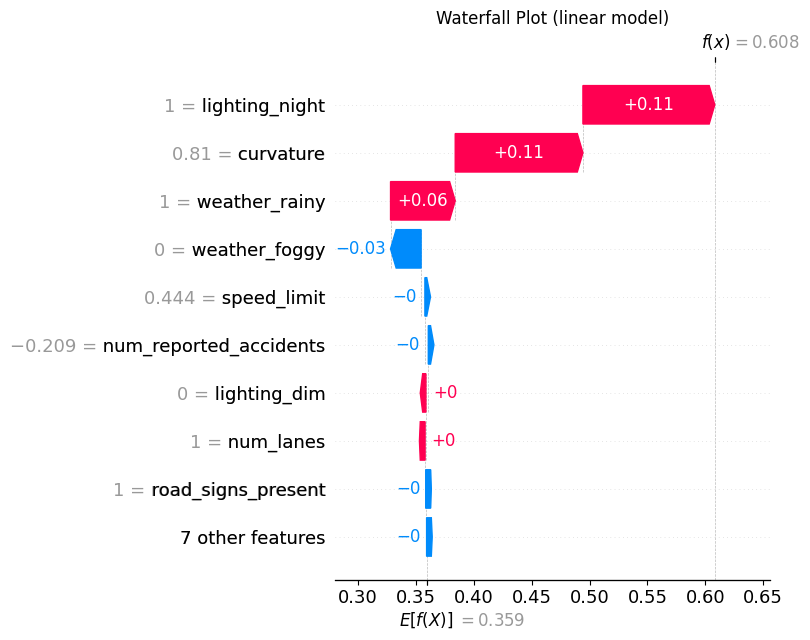

In [40]:
shap_data = X_train_imp.sample(n=100, random_state=42)

explain_model_with_shap(BaseModel.model, shap_data, model_type="linear")

By looking at the SHAP values, we can see that the curvature of the road is the biggest predictor for the accident risk.

Since the model is linear we can also get an idea of feature importance by looking at the coefficients

In [41]:
print(f"Intercept: {BaseModel.model.intercept_}")

importances = pd.Series(BaseModel.model.coef_, index=X.columns)
print(importances.sort_values(ascending=False))

Intercept: -0.012213818714326696
curvature                 0.324297
speed_limit               0.226501
lighting_night            0.178090
weather_foggy             0.082580
weather_rainy             0.082209
num_reported_accidents    0.015494
num_lanes                 0.001454
time_of_day_evening       0.001154
holiday                   0.000702
road_type_urban           0.000663
school_season             0.000324
public_road              -0.000015
road_type_rural          -0.000323
time_of_day_morning      -0.000906
road_signs_present       -0.001191
lighting_dim             -0.007449
dtype: float64


A problem with the linear regressor, is that we dont really know whether the features with small coefficients affect the accident risk or not, or if the model just has overfit to noise, as there is nothing that punishes the model for having non-zero weights

### Model 2 - Lasso

According to the documentation, the optimization objective of Lasso is

```(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1```

The ``alpha * ||w||_1`` (L1 penalty) part is interresting, as it essentually forces unimportant weights to 0.

In [42]:

LassoModel = L1Model()
LassoModel.fit(X_train_imp, Y_train)

Y_predictions_lasso = LassoModel.predict(X_test_imp)

metrics_df = calculate_metrics(Y_test, Y_predictions_lasso, PENALTY_UNDERESTIMATE, "Lasso", df=metrics_df)

metrics_df

,Model,Cost,Standard MAE,RMSE,R2 Score,Underestimated portion,Overestimated portion
0,Linear,0.192780,0.064792,0.083001,0.750327,0.484317,0.515683
1,Lasso,0.192778,0.064792,0.082999,0.750334,0.484452,0.515548


The Lasso model performs about the same as the Linear Regressor

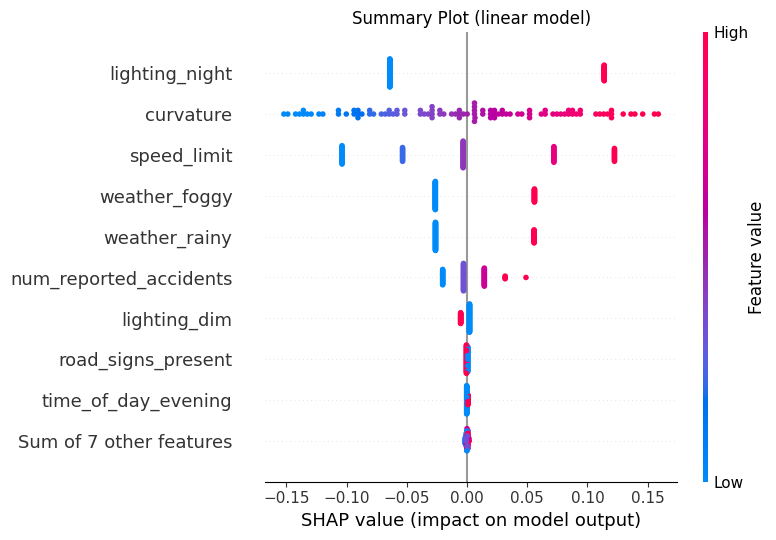

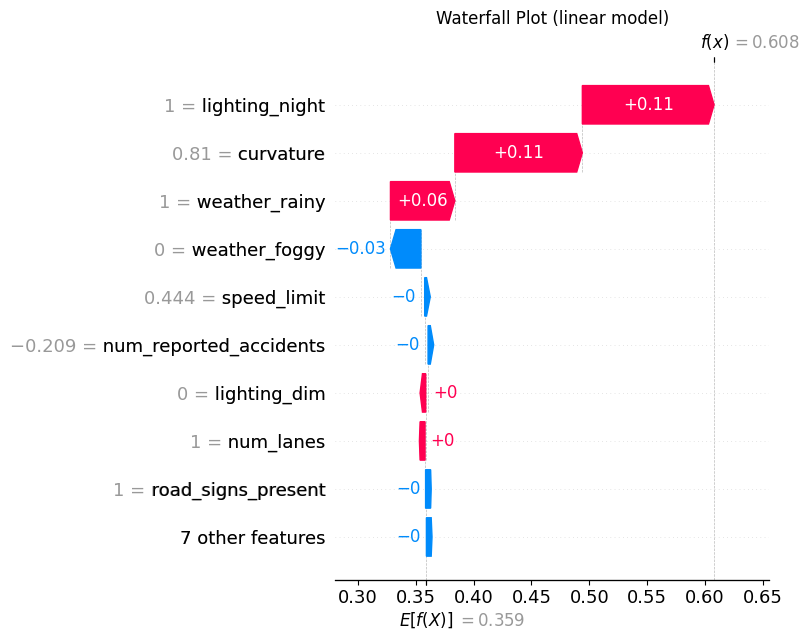

In [43]:
explain_model_with_shap(LassoModel.model, shap_data, model_type="linear")

The SHAP values look almost identical to the linear regressor, with the added benefit of having forced the ``public_road`` weight to 0! Therefore there doesnt seem to be any linear relation between ``public_road`` and accident risk.

In [44]:
print(f"Intercept: {LassoModel.model.intercept_}")

importances_lasso = pd.Series(LassoModel.model.coef_, index=X.columns)
print(importances_lasso.sort_values(ascending=False))

Intercept: -0.011442644247514844
curvature                 0.323812
speed_limit               0.226165
lighting_night            0.177936
weather_foggy             0.082290
weather_rainy             0.081863
num_reported_accidents    0.015493
num_lanes                 0.001194
time_of_day_evening       0.001051
holiday                   0.000593
road_type_urban           0.000569
school_season             0.000186
public_road               0.000000
road_type_rural          -0.000213
time_of_day_morning      -0.000798
road_signs_present       -0.001054
lighting_dim             -0.007349
dtype: float64


### Model 3 - XGBoost

So far we have just tested linear models, which showed good results. The problem with linear models is however just that: they are linear. Lets see if there might be any non-linear relations that we might be able to take advantage of by training a non-linear model using XGBoost

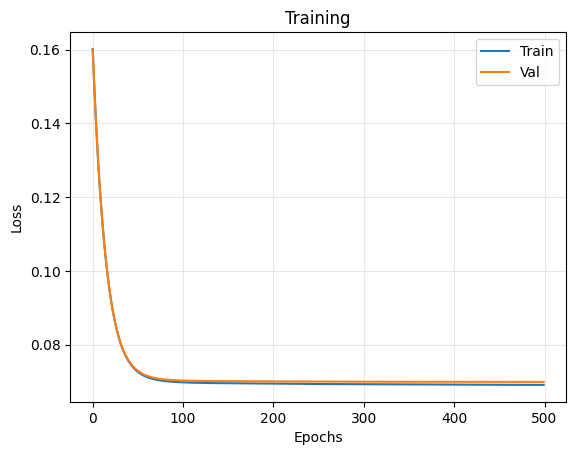

In [45]:
XGBoost = XGBoostModel()
XGBoost.fit(X_train_imp, Y_train, eval_set=[(X_train_imp, Y_train), (X_val_imp, Y_val)])
results_xgboost = XGBoost.model.evals_result()

plot_learning_curves_xgboost(results_xgboost)

In [46]:
Y_predictions_xgboost = XGBoost.predict(X_test_imp)

metrics_df = calculate_metrics(Y_test, Y_predictions_xgboost, PENALTY_UNDERESTIMATE, "XGBoost", df=metrics_df)

metrics_df

,Model,Cost,Standard MAE,RMSE,R2 Score,Underestimated portion,Overestimated portion
0,Linear,0.192780,0.064792,0.083001,0.750327,0.484317,0.515683
1,Lasso,0.192778,0.064792,0.082999,0.750334,0.484452,0.515548
2,XGBoost,0.155283,0.052006,0.069610,0.824387,0.471898,0.528102


XGBoost seems better, beating the linear models on every metric! The cost is however still quite high.

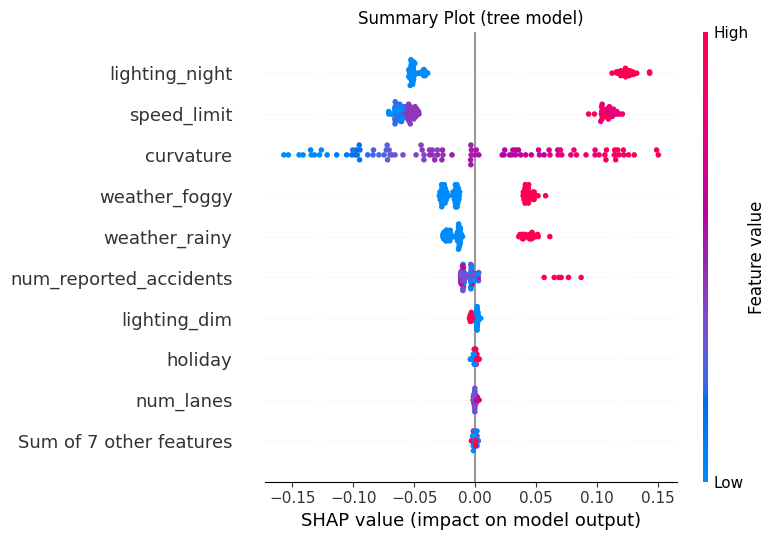

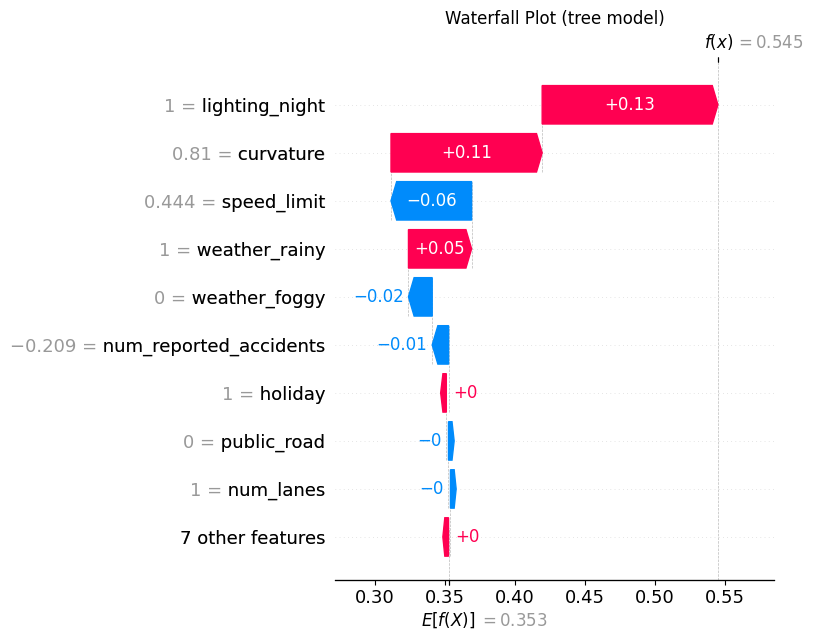

In [47]:
explain_model_with_shap(XGBoost.model, shap_data, model_type="tree")

The same features seem to be important, with curvature and speed limit still being the most important features. We do however get different values, meaning there are most likely some non-linearities in the data that the model is able to take advantage of!

### Model 3 - Neuro Probabilistic Model



Epoch 1/100

203/203 [==============================] - 5s 10ms/step - loss: -0.7288 - val_loss: -1.0416
Epoch 2/100
203/203 [==============================] - 2s 8ms/step - loss: -1.0954 - val_loss: -1.1383
Epoch 3/100
203/203 [==============================] - 2s 8ms/step - loss: -1.1630 - val_loss: -1.1666
Epoch 4/100
203/203 [==============================] - 2s 9ms/step - loss: -1.1975 - val_loss: -1.2079
Epoch 5/100
203/203 [==============================] - 2s 8ms/step - loss: -1.2262 - val_loss: -1.2078
Epoch 6/100
203/203 [==============================] - 2s 8ms/step - loss: -1.2335 - val_loss: -1.2222
Epoch 7/100
203/203 [==============================] - 2s 8ms/step - loss: -1.2362 - val_loss: -1.2327
Epoch 8/100
203/203 [==============================] - 2s 9ms/step - loss: -1.2392 - val_loss: -1.2197
Epoch 9/100
203/203 [==============================] - 2s 8ms/step - loss: -1.2411 - val_loss: -1.2344
Epoch 10/100
203/203 [==============================] - 2s 8ms/step -

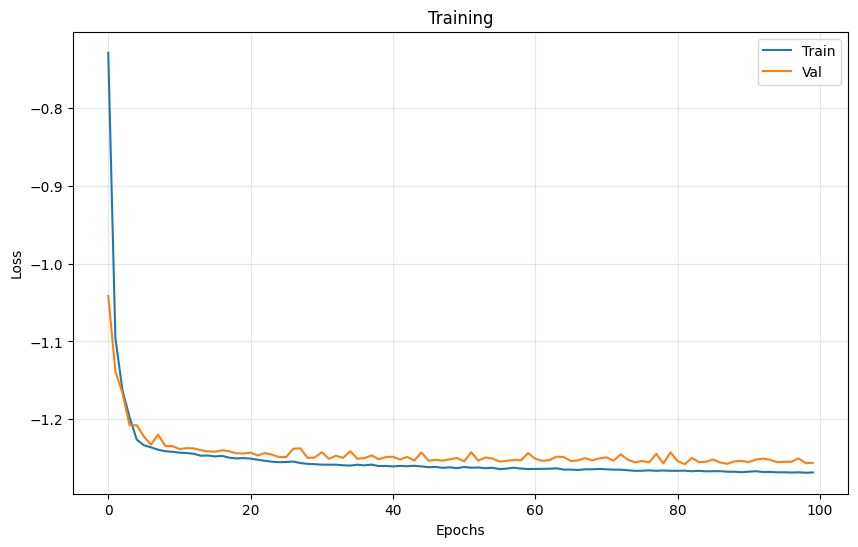

In [48]:
NeuroModel = NeuroProbabilisticModel()
history_neuro = NeuroModel.fit(X_train_imp, Y_train, epochs=100, validation_data=(X_val_imp, Y_val))

plot_learning_curves_neuro(history_neuro)

In [49]:
Y_predictions_neuro = NeuroModel.predict(X_test_imp)

metrics_df = calculate_metrics(Y_test, Y_predictions_neuro, PENALTY_UNDERESTIMATE, "Neuro", df=metrics_df)

metrics_df

,Model,Cost,Standard MAE,RMSE,R2 Score,Underestimated portion,Overestimated portion
0,Linear,0.192780,0.064792,0.083001,0.750327,0.484317,0.515683
1,Lasso,0.192778,0.064792,0.082999,0.750334,0.484452,0.515548
2,XGBoost,0.155283,0.052006,0.069610,0.824387,0.471898,0.528102
3,Neuro,0.164170,0.052400,0.070278,0.821002,0.497238,0.502762


PermutationExplainer explainer: 101it [01:05,  1.52it/s]                         


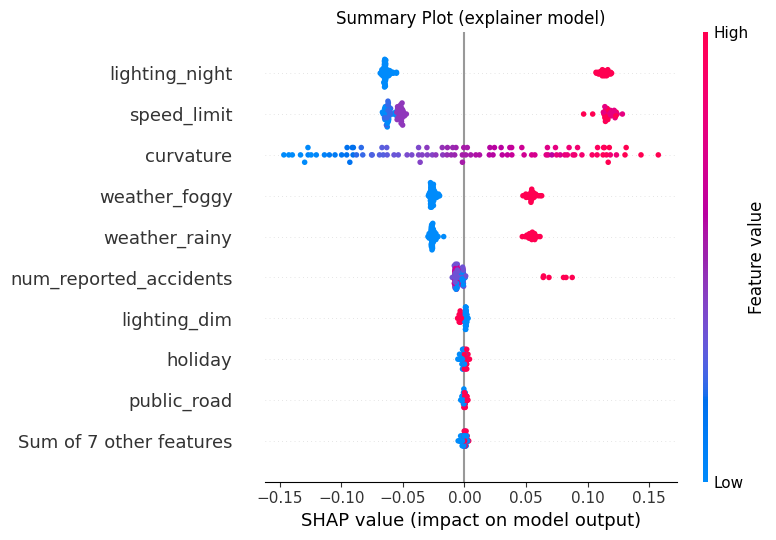

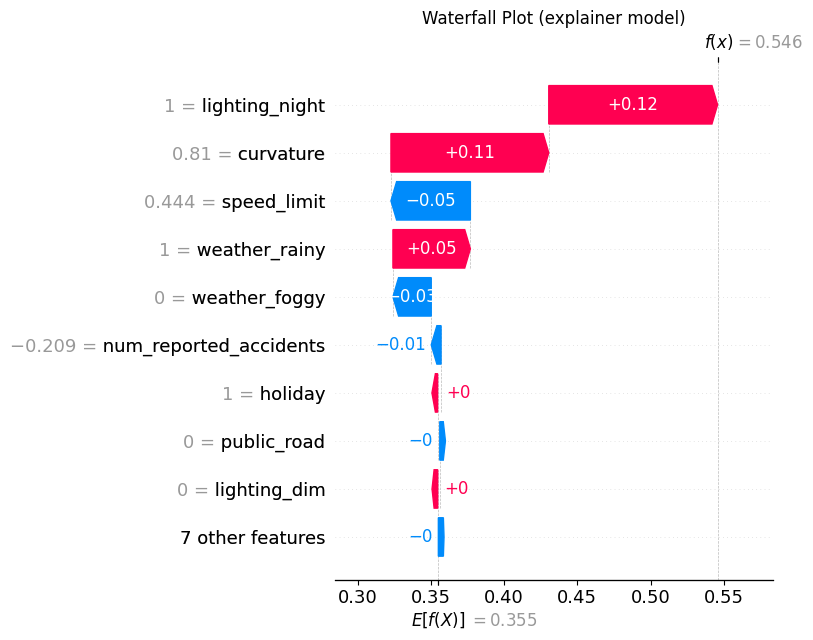

In [50]:
# Explain means
explain_model_with_shap(NeuroModel.predict_mean, shap_data, model_type="explainer")

PermutationExplainer explainer: 101it [00:43,  1.76it/s]                         


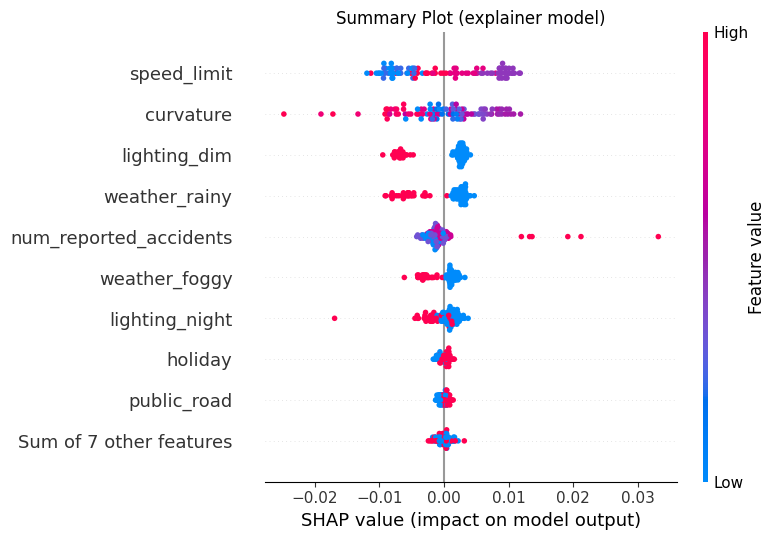

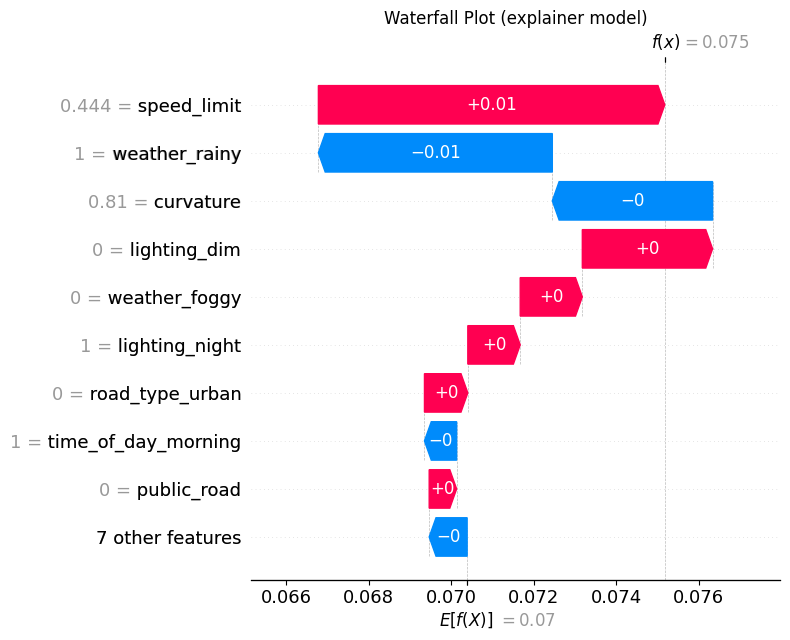

In [51]:
explain_model_with_shap(NeuroModel.predict_std, shap_data, model_type="explainer")

Since σ doesnt vary that much, most of the SHAP values are close to 0

### Model 4 - Custom Loss

A problem with all models so far is that their optimization goals are different than our goal. We want to limit underestimation. To do this, we have to align the models goal with our custom loss that punishes underestimation.

Epoch 1/100
203/203 [==============================] - 4s 10ms/step - loss: -1.2279 - val_loss: -1.8287
Epoch 2/100
203/203 [==============================] - 2s 8ms/step - loss: -2.0436 - val_loss: -2.2496
Epoch 3/100
203/203 [==============================] - 2s 8ms/step - loss: -2.1057 - val_loss: -2.2315
Epoch 4/100
203/203 [==============================] - 2s 8ms/step - loss: -2.1430 - val_loss: -2.1104
Epoch 5/100
203/203 [==============================] - 2s 8ms/step - loss: -2.1888 - val_loss: -2.6471
Epoch 6/100
203/203 [==============================] - 2s 8ms/step - loss: -2.2129 - val_loss: -2.0481
Epoch 7/100
203/203 [==============================] - 2s 8ms/step - loss: -2.2230 - val_loss: -2.1623
Epoch 8/100
203/203 [==============================] - 2s 9ms/step - loss: -2.2213 - val_loss: -2.3156
Epoch 9/100
203/203 [==============================] - 2s 8ms/step - loss: -2.2270 - val_loss: -2.3472
Epoch 10/100
203/203 [==============================] - 2s 8ms/step - lo

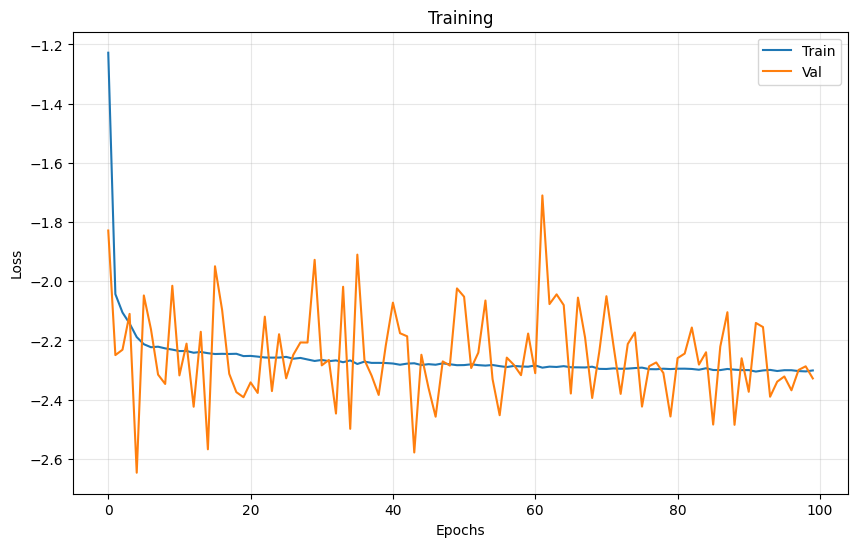

In [52]:
custom_loss = CustomNeuroLoss(penalty_underestimate=PENALTY_UNDERESTIMATE)

CustomLossNeuroModel = NeuroProbabilisticModel(custom_loss=custom_loss)
history_neurocustom = CustomLossNeuroModel.fit(X_train_imp, Y_train, epochs=100, validation_data=(X_val_imp, Y_val))

plot_learning_curves_neuro(history_neurocustom)

In [53]:
Y_predictions_neurocustom = CustomLossNeuroModel.predict(X_test_imp)

metrics_df = calculate_metrics(Y_test, Y_predictions_neurocustom, PENALTY_UNDERESTIMATE, "Custom Loss Neuro", df=metrics_df)

metrics_df

,Model,Cost,Standard MAE,RMSE,R2 Score,Underestimated portion,Overestimated portion
0,Linear,0.192780,0.064792,0.083001,0.750327,0.484317,0.515683
1,Lasso,0.192778,0.064792,0.082999,0.750334,0.484452,0.515548
2,XGBoost,0.155283,0.052006,0.069610,0.824387,0.471898,0.528102
3,Neuro,0.164170,0.052400,0.070278,0.821002,0.497238,0.502762
4,Custom Loss Neuro,0.112035,0.066119,0.083108,0.749679,0.236673,0.763327


The result is a slightly higher MAE, but a much lower cost as the amount of underestimations have gone down greatly!

PermutationExplainer explainer: 101it [00:44,  1.75it/s]                         


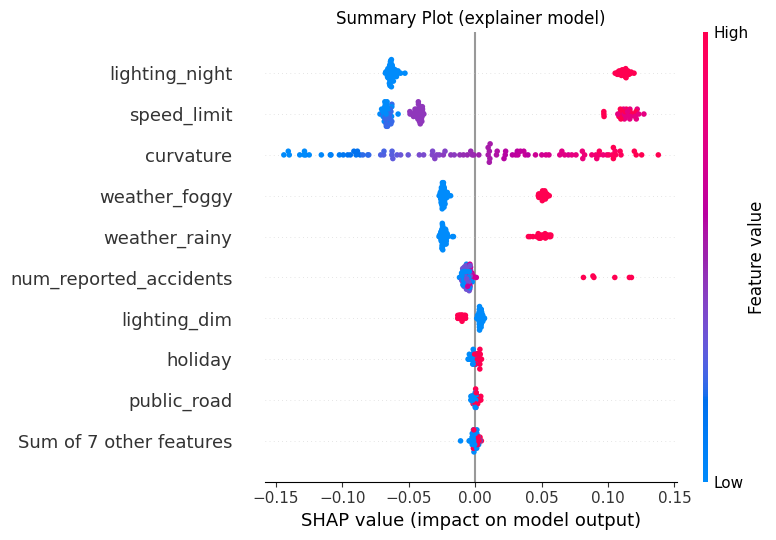

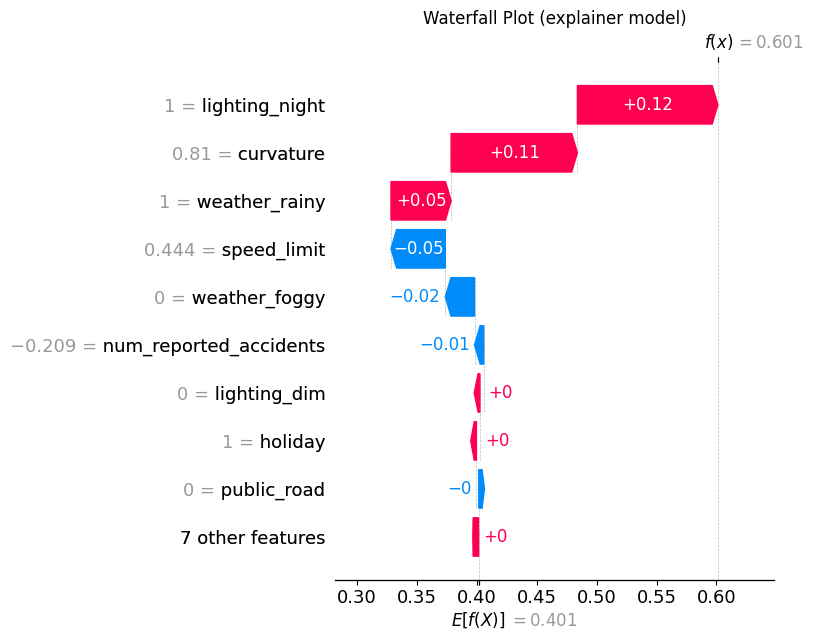

In [54]:
explain_model_with_shap(CustomLossNeuroModel.predict_mean, shap_data, model_type="explainer")

PermutationExplainer explainer: 101it [00:42,  1.83it/s]                         


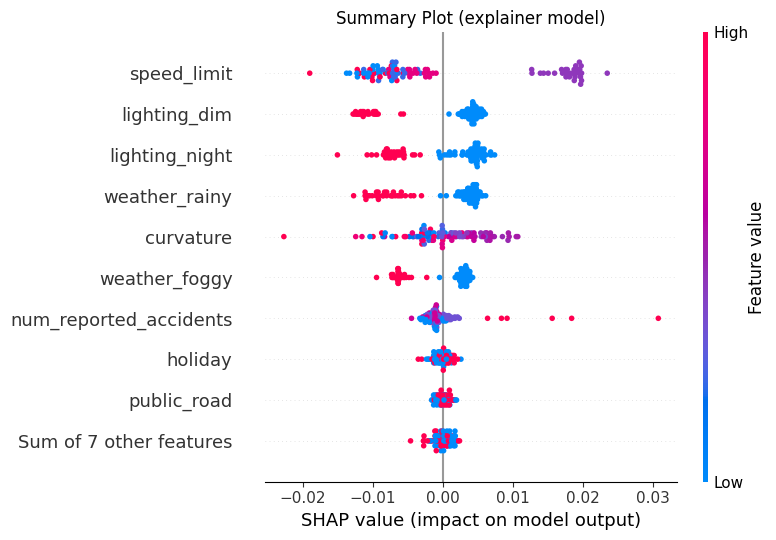

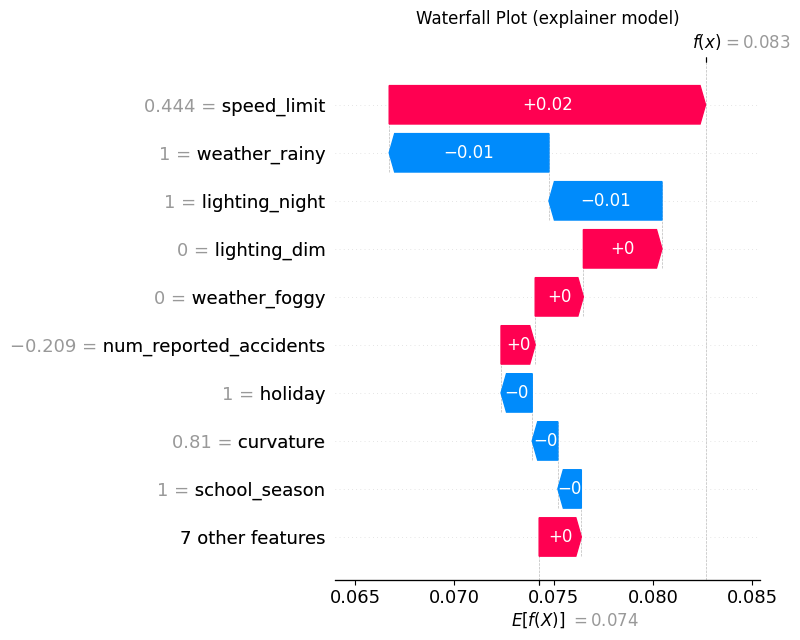

In [55]:
explain_model_with_shap(CustomLossNeuroModel.predict_std, shap_data, model_type="explainer")